[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/cheminformatics-workflow/notebooks/13-Clustering.ipynb)

# Clustering

- Separating compounds into multiple groups (cluster) can be useful to determine most common structure patterns.
- Clustering is done based on molecular descriptors space representation of chemical structures.
- Clustering techniques can be devided into three groups:
    - 1. Supervised: efficiency of separation is determined by homogeneity of activity within clusters.
    - 2. Unsupervised: efficiency of serparation is determined by degree of discrimination between clusters based on descriptors space alone.
    - 3. Mixed of the previous techniques.

## K-mean clustering (KMC)

- Unsupervised learning algorithm.
- KMC is an algorithm that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centroid).

## Kohonen self-organizing maps (SOM)

SOM produce a low-dimensional (typically two-dimensional)representation of a higher dimensional data set using artificial neural network algorithm.

### Differences

KMC clusters are directionless, i.e., cluster 1 and 2 don't have to be similar in cluster memebers.

## Taylor-Butina
The Taylor-Butina clustering method is a popular and efficient non-hierarchical method for clustering large datasets of molecular fingerprints. It's especially useful in the field of cheminformatics for compound library selection, diversity analysis, and high-throughput screening data analysis.

The basic idea behind Butina clustering is to:

- Pre-compute pairwise similarities between all molecules in the dataset.
- Sort these similarities.
- For each molecule, identify neighbors that are above a certain similarity threshold.
- Create clusters such that the largest unclustered molecule (by neighbor count) becomes the centroid of a new cluster, and all its neighbors are assigned to this cluster.


## Content

1. [Load Libraries](#1)
2. [Load Data](#2)
3. [K-mean clustering](#3)
    - 3.1 [Optimization](#4)
4. [Taylor-Butina Clustering](#5)
5. [Summary](#6)

## 1. Load Libraries<a name = 1></a>

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 36.2 MB/s eta 0:00:00


In [ ]:
!pip install mols2grid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
import stat
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#--------------------------------------------------------------

from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.ML.Cluster import Butina
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
import mols2grid

#--------------------------------------------------------------

import sklearn.metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE

## 2. Load Data<a name = 2></a>

In [ ]:
data = PandasTools.LoadSDF('AID_1259247_sanitized.sdf', molColName='Molecule')

In [ ]:
data.head()

PUBCHEM_SMILES PUBCHEM_ACTIVITY_OUTCOME  \
0  CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...                   Active   
1  C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O                   Active   
2  C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...                   Active   
3  CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...                   Active   
4            CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2                   Active   

  Antagonist Activity Viability Activity Antagonist Efficacy (%) ID  \
0   active antagonist           inactive                -37.5702      
1   active antagonist           inactive                -37.9252      
2   active antagonist           inactive                 -35.847      
3   active antagonist           inactive                -35.5194      
4   active antagonist           inactive                -39.4007      

                                           Molecule  
0  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>  
1  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>  
2  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>  
3  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>  
4  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db300>

In [ ]:
len(data)

5134

In [ ]:
data['Antagonist Efficacy (%)'] = data['Antagonist Efficacy (%)'].astype('float64')

In [ ]:
fingerprints = pd.read_csv('/content/morgan_fps.csv')
fingerprints.head()

PUBCHEM_SMILES PUBCHEM_ACTIVITY_OUTCOME  \
0  CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...                   Active   
1  C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O                   Active   
2  C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...                   Active   
3  CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...                   Active   
4            CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2                   Active   

  Antagonist Activity Viability Activity  Antagonist Efficacy (%)  ID  \
0   active antagonist           inactive                 -37.5702 NaN   
1   active antagonist           inactive                 -37.9252 NaN   
2   active antagonist           inactive                 -35.8470 NaN   
3   active antagonist           inactive                 -35.5194 NaN   
4   active antagonist           inactive                 -39.4007 NaN   

                                           Molecule  Col_0  Col_1  Col_2  ...  \
0  <rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2c00>      0      0      0  ...   
1  <rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2e30>      0      0      0  ...   
2  <rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2ea0>      0      0      0  ...   
3  <rdkit.Chem.rdchem.Mol object at 0x7ddc51bc2f80>      0      0      0  ...   
4  <rdkit.Chem.rdchem.Mol object at 0x7ddc51bc3060>      0      0      0  ...   

   Col_2038  Col_2039  Col_2040  Col_2041  Col_2042  Col_2043  Col_2044  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         1         0         0   

   Col_2045  Col_2046  Col_2047  
0         0         0         0  
1         0         0         0  
2         0         0         0  
3         0         0         0  
4         0         0         0  

[5 rows x 2055 columns]

In [ ]:
len(fingerprints)

5134

In [ ]:
fingerprints.columns

Index(['PUBCHEM_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'Antagonist Activity',
       'Viability Activity', 'Antagonist Efficacy (%)', 'ID', 'Molecule',
       'Col_0', 'Col_1', 'Col_2',
       ...
       'Col_2038', 'Col_2039', 'Col_2040', 'Col_2041', 'Col_2042', 'Col_2043',
       'Col_2044', 'Col_2045', 'Col_2046', 'Col_2047'],
      dtype='object', length=2055)

In [ ]:
fingerprints.drop(['PUBCHEM_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'Antagonist Activity',
       'Viability Activity', 'Antagonist Efficacy (%)', 'ID', 'Molecule'], axis = 1, inplace = True)

In [ ]:
fingerprints

Col_0  Col_1  Col_2  Col_3  Col_4  Col_5  Col_6  Col_7  Col_8  Col_9  \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      0      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5129      0      0      0      0      0      0      0      0      0      0   
5130      0      1      0      0      0      0      0      0      0      0   
5131      0      0      0      0      0      0      0      0      0      0   
5132      0      1      0      0      0      0      0      0      0      0   
5133      0      0      0      0      0      0      0      0      0      0   

      ...  Col_2038  Col_2039  Col_2040  Col_2041  Col_2042  Col_2043  \
0     ...         0         0         0         0         0         0   
1     ...         0         0         0         0         0         0   
2     ...         0         0         0         0         0         0   
3     ...         0         0         0         0         0         0   
4     ...         0         0         0         0         1         0   
...   ...       ...       ...       ...       ...       ...       ...   
5129  ...         0         0         0         0         0         0   
5130  ...         0         0         0         0         0         0   
5131  ...         0         0         0         0         0         0   
5132  ...         0         0         0         0         0         0   
5133  ...         0         0         0         0         0         0   

      Col_2044  Col_2045  Col_2046  Col_2047  
0            0         0         0         0  
1            0         0         0         0  
2            0         0         0         0  
3            0         0         0         0  
4            0         0         0         0  
...        ...       ...       ...       ...  
5129         0         0         0         0  
5130         0         0         0         0  
5131         0         0         0         0  
5132         0         0         0         0  
5133         0         0         0         0  

[5134 rows x 2048 columns]

In [ ]:
data_fnps = pd.concat([data, fingerprints], axis=1)
data_fnps.drop('ID', axis = 1, inplace = True)
data_fnps

PUBCHEM_SMILES  \
0     CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...   
1     C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O   
2     C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...   
3     CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...   
4               CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2   
...                                                 ...   
5129                                       C(/C=C\Cl)Cl   
5130                              CC(C)OP(OC(C)C)OC(C)C   
5131                                            C1CCSC1   
5132                          CN(CCCC(C1=CN=CC=C1)O)N=O   
5133                         CN(CCCC(=O)C1=CN=CC=C1)N=O   

     PUBCHEM_ACTIVITY_OUTCOME Antagonist Activity Viability Activity  \
0                      Active   active antagonist           inactive   
1                      Active   active antagonist           inactive   
2                      Active   active antagonist           inactive   
3                      Active   active antagonist           inactive   
4                      Active   active antagonist           inactive   
...                       ...                 ...                ...   
5129                 Inactive            inactive           inactive   
5130                 Inactive            inactive           inactive   
5131                 Inactive            inactive           inactive   
5132                 Inactive            inactive           inactive   
5133                 Inactive            inactive           inactive   

      Antagonist Efficacy (%)  \
0                    -37.5702   
1                    -37.9252   
2                    -35.8470   
3                    -35.5194   
4                    -39.4007   
...                       ...   
5129                   0.0000   
5130                   0.0000   
5131                   0.0000   
5132                   0.0000   
5133                   0.0000   

                                              Molecule  Col_0  Col_1  Col_2  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>      0      0      0   
1     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>      0      0      0   
2     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>      0      0      0   
3     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>      0      0      0   
4     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db300>      0      0      0   
...                                                ...    ...    ...    ...   
5129  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bae0>      0      0      0   
5130  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bb50>      0      1      0   
5131  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bbc0>      0      0      0   
5132  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bc30>      0      1      0   
5133  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bca0>      0      0      0   

      Col_3  ...  Col_2038  Col_2039  Col_2040  Col_2041  Col_2042  Col_2043  \
0         0  ...         0         0         0         0         0         0   
1         0  ...         0         0         0         0         0         0   
2         0  ...         0         0         0         0         0         0   
3         0  ...         0         0         0         0         0         0   
4         0  ...         0         0         0         0         1         0   
...     ...  ...       ...       ...       ...       ...       ...       ...   
5129      0  ...         0         0         0         0         0         0   
5130      0  ...         0         0         0         0         0         0   
5131      0  ...         0         0         0         0         0         0   
5132      0  ...         0         0         0         0         0         0   
5133      0  ...         0         0         0         0         0         0   

      Col_2044  Col_2045  Col_2046  Col_2047  
0            0         0         0         0  
1            0         0         0         0  
2            0     

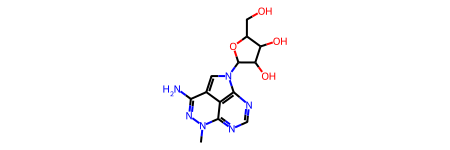

In [ ]:
data_fnps['Molecule'][0]

## 3. K-means Clustering<a name = 3></a>

In [ ]:
import sklearn as sk
from sklearn.cluster import KMeans

In [ ]:
kmc = KMeans(n_clusters=12, random_state=1, n_init='auto')
kmc.fit(fingerprints)

KMeans(n_clusters=12, n_init='auto', random_state=1)

In [ ]:
# Get the cluster labels for each molecule

cluster_kmc = kmc.labels_

In [ ]:
len(cluster_kmc)

5134

In [ ]:
cluster_kmc

array([ 7,  7,  7, ...,  5,  9, 10], dtype=int32)

In [ ]:
# Output the cluster labels
cluster_labels = {}

for k_index, label in zip(fingerprints.index, cluster_kmc):
    cluster_labels[k_index] = label
    # print(f"Molecule {ksx_index} is in Cluster {label}")

In [ ]:
cluster_labels_df = pd.DataFrame(list(cluster_labels.items()), columns=['Molecule', 'Cluster label'])
cluster_labels_df['SMILES'] = data_fnps['PUBCHEM_SMILES']
cluster_labels_df['Molecule'] = data_fnps['Molecule']
cluster_labels_df

Molecule  Cluster label  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>              7   
1     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>              7   
2     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>              7   
3     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>              4   
4     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db300>              2   
...                                                ...            ...   
5129  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bae0>              5   
5130  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bb50>              5   
5131  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bbc0>              5   
5132  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bc30>              9   
5133  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bca0>             10   

                                                 SMILES  
0     CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...  
1     C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O  
2     C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...  
3     CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...  
4               CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2  
...                                                 ...  
5129                                       C(/C=C\Cl)Cl  
5130                              CC(C)OP(OC(C)C)OC(C)C  
5131                                            C1CCSC1  
5132                          CN(CCCC(C1=CN=CC=C1)O)N=O  
5133                         CN(CCCC(=O)C1=CN=CC=C1)N=O  

[5134 rows x 3 columns]

In [ ]:
mols2grid.display(cluster_labels_df, smiles_col = 'SMILES', mol_col = 'Molecule',
                  subset = ['Cluster label'])

MolGridWidget()

In [ ]:
# Sorting by the count values
data_to_plot = cluster_labels_df['Cluster label'].value_counts().sort_index()
data_to_plot

0       2
1     237
2     181
3     357
4     899
5     789
6     376
7     466
8      27
9     638
10    602
11    560
Name: Cluster label, dtype: int64

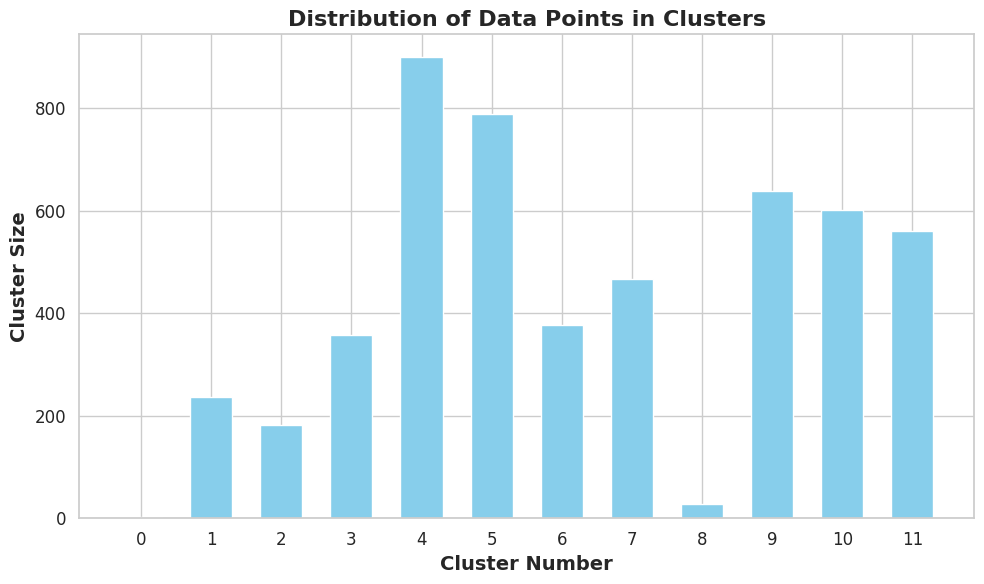

In [ ]:
# Set a style
sns.set(style="whitegrid")

# Creating the bar plot with adjusted bar width and color
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size
bars = ax.bar(data_to_plot.index, data_to_plot.values, color='skyblue', width=0.6)

# Setting labels and title with customized font sizes
ax.set_xlabel("Cluster Number", fontsize=14, fontweight='bold')
ax.set_ylabel("Cluster Size", fontsize=14, fontweight='bold')
ax.set_title("Distribution of Data Points in Clusters", fontsize=16, fontweight='bold')

# Customize tick labels
ax.set_xticks(data_to_plot.index)
ax.set_xticklabels(data_to_plot.index, fontsize=12)
plt.yticks(fontsize=12)

# Adding grid lines
ax.yaxis.grid(True)

# Displaying the plot
plt.tight_layout()  # Adjusts the plot to fit into the figure area
plt.savefig('k-mean_cluster_distribution.pdf', bbox_inches='tight')
plt.show()

One of the drawback of K-means clustering is that we need to input the number of clusters. To determine the optium number of cluster is by maximizing the silhouette score.

### 3.1 Optimization<a name = 4></a>

In [ ]:
#This part of the code was taken and inspired by the Pat Walters's blog and GitHub:
# https://github.com/PatWalters/practical_cheminformatics_tutorials/blob/main/clustering/kmeans_clustering.ipynb

cluster_range = range(5,25)
score_list = []
for k in cluster_range:
    km = KMeans(n_clusters=k,random_state=42,n_init='auto')
    cluster_labels = km.fit_predict(fingerprints)
    score = silhouette_score(fingerprints,cluster_labels)
    score_list.append([k,score])

In [ ]:
score_list

[[5, 0.006742738216597883],
 [6, -0.006580481115596522],
 [7, -0.006829567645981254],
 [8, -0.004464478843502702],
 [9, 0.0007710055759685714],
 [10, 0.002242408453587282],
 [11, 0.002263844984408743],
 [12, -0.013822464285596922],
 [13, -0.00981079333853972],
 [14, -0.011341069115532322],
 [15, -0.005895095411399134],
 [16, -0.005062430182070247],
 [17, -0.015399602445489772],
 [18, -0.013274501040639836],
 [19, -0.01221510979672921],
 [20, -0.009211077887860457],
 [21, -0.01660548506237846],
 [22, -0.012357537784017126],
 [23, -0.013480769566647628],
 [24, -0.026831729467122714]]

In [ ]:
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])
score_df[:5]

K  Silhouette Score
0  5          0.006743
1  6         -0.006580
2  7         -0.006830
3  8         -0.004464
4  9          0.000771

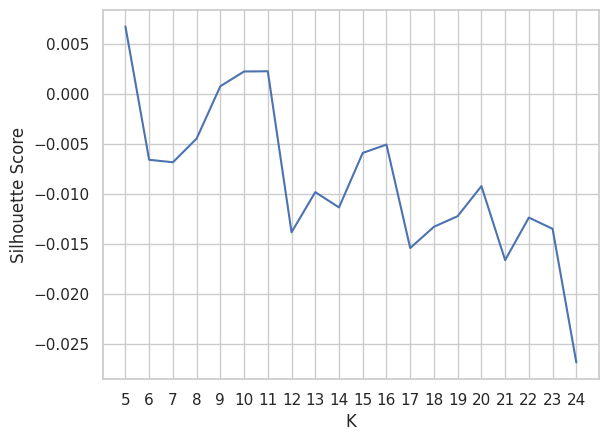

In [ ]:
ax = sns.lineplot(x="K",y="Silhouette Score",data=score_df)
ax.set_xticks(cluster_range);

In [ ]:
kmc_opt = KMeans(n_clusters=5, random_state=1, n_init='auto')
clusters_opt = kmc_opt.fit(fingerprints)

In [ ]:
# Get the optimized cluster labels for each molecule

cluster_kmc_opt = kmc_opt.labels_

In [ ]:
len(cluster_kmc_opt)

5134

In [ ]:
cluster_kmc_opt

array([1, 1, 1, ..., 3, 1, 2], dtype=int32)

In [ ]:
# Output the cluster labels
cluster_labels_opt = {}

for k_index, label in zip(fingerprints.index, cluster_kmc_opt):
    cluster_labels_opt[k_index] = label
    # print(f"Molecule {ksx_index} is in Cluster {label}")

In [ ]:
cluster_labels_opt_df = pd.DataFrame(list(cluster_labels_opt.items()), columns=['Molecule', 'Cluster label'])
cluster_labels_opt_df['SMILES'] = data_fnps['PUBCHEM_SMILES']
cluster_labels_opt_df['Molecule'] = data_fnps['Molecule']
cluster_labels_opt_df['Antagonist Efficacy (%)'] = data_fnps['Antagonist Efficacy (%)']

cluster_labels_opt_df

Molecule  Cluster label  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>              1   
1     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>              1   
2     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>              1   
3     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>              1   
4     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db300>              2   
...                                                ...            ...   
5129  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bae0>              3   
5130  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bb50>              3   
5131  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bbc0>              3   
5132  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bc30>              1   
5133  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bca0>              2   

                                                 SMILES  \
0     CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...   
1     C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O   
2     C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...   
3     CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...   
4               CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2   
...                                                 ...   
5129                                       C(/C=C\Cl)Cl   
5130                              CC(C)OP(OC(C)C)OC(C)C   
5131                                            C1CCSC1   
5132                          CN(CCCC(C1=CN=CC=C1)O)N=O   
5133                         CN(CCCC(=O)C1=CN=CC=C1)N=O   

      Antagonist Efficacy (%)  
0                    -37.5702  
1                    -37.9252  
2                    -35.8470  
3                    -35.5194  
4                    -39.4007  
...                       ...  
5129                   0.0000  
5130                   0.0000  
5131                   0.0000  
5132                   0.0000  
5133                   0.0000  

[5134 rows x 4 columns]

In [ ]:
mols2grid.display(cluster_labels_opt_df, smiles_col = 'SMILES', mol_col = 'Molecule',
                  subset = ['Cluster label', 'Antagonist Efficacy (%)'])

MolGridWidget()

In [ ]:
# Sorting by the count values
data_to_plot_opt = cluster_labels_opt_df['Cluster label'].value_counts().sort_index()
data_to_plot_opt

0       2
1    1494
2    1333
3    1765
4     540
Name: Cluster label, dtype: int64

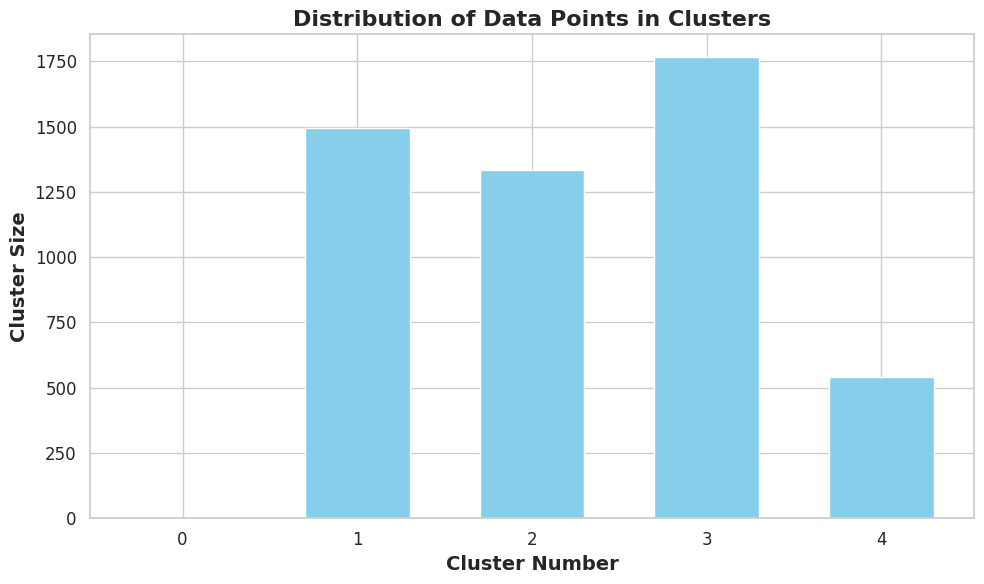

In [ ]:
# Set a style
sns.set(style="whitegrid")

# Creating the bar plot with adjusted bar width and color
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size
bars = ax.bar(data_to_plot_opt.index, data_to_plot_opt.values, color='skyblue', width=0.6)

# Setting labels and title with customized font sizes
ax.set_xlabel("Cluster Number", fontsize=14, fontweight='bold')
ax.set_ylabel("Cluster Size", fontsize=14, fontweight='bold')
ax.set_title("Distribution of Data Points in Clusters", fontsize=16, fontweight='bold')

# Customize tick labels
ax.set_xticks(data_to_plot_opt.index)
ax.set_xticklabels(data_to_plot_opt.index, fontsize=12)
plt.yticks(fontsize=12)

# Adding grid lines
ax.yaxis.grid(True)

# Displaying the plot
plt.tight_layout()  # Adjusts the plot to fit into the figure area
plt.savefig('k-mean_cluster_distribution_optimized.pdf', bbox_inches='tight')
plt.show()

In [ ]:
cluster_labels_opt_df = cluster_labels_opt_df.copy()
cluster_labels_opt_df['Cluster'] = clusters_opt
cluster_labels_opt_df

Molecule  Cluster label  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>              1   
1     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>              1   
2     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>              1   
3     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>              1   
4     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db300>              2   
...                                                ...            ...   
5129  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bae0>              3   
5130  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bb50>              3   
5131  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bbc0>              3   
5132  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bc30>              1   
5133  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bca0>              2   

                                                 SMILES  \
0     CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...   
1     C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O   
2     C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...   
3     CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...   
4               CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2   
...                                                 ...   
5129                                       C(/C=C\Cl)Cl   
5130                              CC(C)OP(OC(C)C)OC(C)C   
5131                                            C1CCSC1   
5132                          CN(CCCC(C1=CN=CC=C1)O)N=O   
5133                         CN(CCCC(=O)C1=CN=CC=C1)N=O   

      Antagonist Efficacy (%)  \
0                    -37.5702   
1                    -37.9252   
2                    -35.8470   
3                    -35.5194   
4                    -39.4007   
...                       ...   
5129                   0.0000   
5130                   0.0000   
5131                   0.0000   
5132                   0.0000   
5133                   0.0000   

                                                Cluster  
0     KMeans(n_clusters=5, n_init='auto', random_sta...  
1     KMeans(n_clusters=5, n_init='auto', random_sta...  
2     KMeans(n_clusters=5, n_init='auto', random_sta...  
3     KMeans(n_clusters=5, n_init='auto', random_sta...  
4     KMeans(n_clusters=5, n_init='auto', random_sta...  
...                                                 ...  
5129  KMeans(n_clusters=5, n_init='auto', random_sta...  
5130  KMeans(n_clusters=5, n_init='auto', random_sta...  
5131  KMeans(n_clusters=5, n_init='auto', random_sta...  
5132  KMeans(n_clusters=5, n_init='auto', random_sta...  
5133  KMeans(n_clusters=5, n_init='auto', random_sta...  

[5134 rows x 5 columns]

Let's display cluster 1

In [ ]:
display = cluster_labels_opt_df.loc[cluster_labels_opt_df['Cluster label'] == 1]

In [ ]:
mols2grid.display(display, smiles_col = 'SMILES', mol_col = 'Molecule', subset=["Cluster label", "Antagonist Efficacy (%)"])

MolGridWidget()

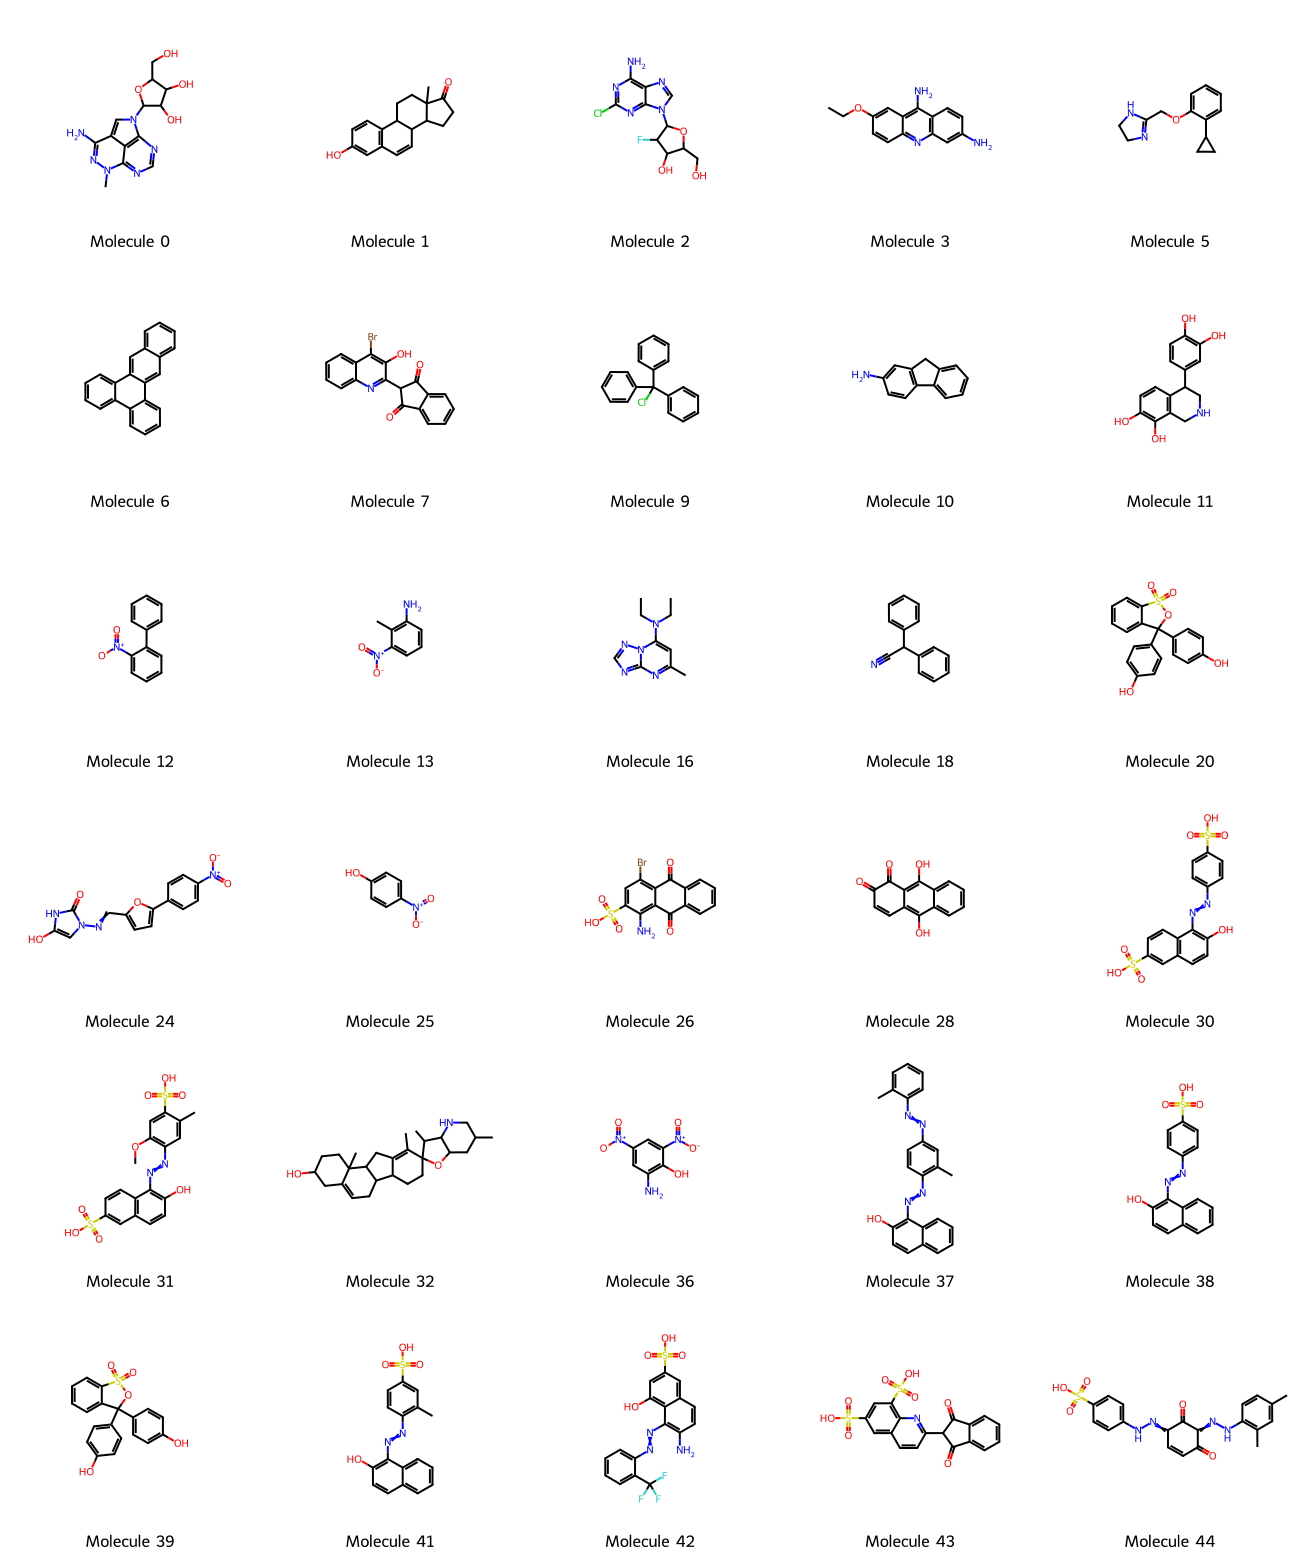

In [ ]:
# Visualize the compounds

# Visualizing Molecules
legends = [f'Molecule {i}' for i in display.index]
molecules = display['Molecule'][:30]
img = Draw.MolsToGridImage(molecules, subImgSize=(260, 260), molsPerRow=5, legends=legends)
img

In [ ]:
!pip install cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 880.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
svg = img.data
svg_filename = "k-means-cluster_1.svg"
with open(svg_filename, "w") as svg_file:
    svg_file.write(svg)

# Convert svg to pdf
import cairosvg

pdf_filename = svg_filename.replace(".svg", ".pdf")
cairosvg.svg2pdf(url=svg_filename, write_to=pdf_filename)

## 5. Taylor-Butina Clustering<a name = 5></a>

The Taylor-Butina clustering method is a popular and efficient non-hierarchical method for clustering large datasets of molecular fingerprints. It's especially useful in the field of cheminformatics for compound library selection, diversity analysis, and high-throughput screening data analysis.

The basic idea behind Butina clustering is to:

- Pre-compute pairwise similarities between all molecules in the dataset.
- Sort these similarities.
- For each molecule, identify neighbors that are above a certain similarity threshold.
- Create clusters such that the largest unclustered molecule (by neighbor count) becomes the centroid of a new cluster, and all its neighbors are assigned to this cluster.

Step-by-step:

1. Distance Calculation: For every molecule in the dataset, calculate the distance (or dissimilarity, which is $1 - similarity$) to every other molecule. This results in a distance matrix.

2. Sorting: The distances are sorted in ascending order.

3. Thresholding: A threshold for the distance (or similarity) is defined. Any molecule within this threshold distance is considered a neighbor.

4. Centroid Selection: The molecule with the most neighbors is selected as the centroid of the next cluster.

5. Cluster Formation: All neighbors of the centroid (within the threshold) are added to its cluster.

6. Iteration: Steps 4 and 5 are repeated until all molecules are assigned to clusters.

7. Singleton Clusters: Any molecule that doesn't belong to any cluster becomes a singleton cluster.

A great blog entry about this topic: http://practicalcheminformatics.blogspot.com/2021/07/viewing-clustered-chemical-structures.html
From which I took inspiration together with the graet tutorial from Gashaw M. Goshu.

In [ ]:
# Inspiration from Pat Walters: https://github.com/PatWalters/workshop/blob/master/clustering/taylor_butina.ipynb
# and Gashaw M. Goshu: https://github.com/gashawmg/Molecular-fingerprints/blob/main/Calculating%20molecular%20fingerprints%20available%20in%20RDkit%20.ipynb

def flexible_butina_cluster(data, cutoff=0.35, precomputed_fps=False, nBits=2048):
    """
    Cluster molecules using the Butina algorithm.

    Parameters:
    - data (list): List of molecules (as RDKit Mol objects) or fingerprints (as BitVects),
                  depending on precomputed_fps.
    - cutoff (float): Distance threshold for clustering.
    - precomputed_fps (bool): Flag to indicate if data contains precomputed fingerprints.
    - nBits (int): Number of bits for the fingerprint. Only relevant if fingerprints need to be computed.

    Returns:
    - list: List of cluster IDs corresponding to each molecule/fingerprint.

    Usage:
    1. If you have precomputed fingerprints:
       >>> results = flexible_butina_cluster(precomputed_fingerprints, precomputed_fps=True)

    2. If you have raw molecules and need to compute fingerprints:
       >>> results = flexible_butina_cluster(list_of_molecules)
    """

    # If fingerprints are not precomputed, compute them
    if not precomputed_fps:
        data = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nBits) for m in data]

    # Calculate pairwise distances
    dists = []
    ndata = len(data)
    for i in range(1, ndata):
        sims = DataStructs.BulkTanimotoSimilarity(data[i], data[:i])
        dists.extend([1-x for x in sims])

    # Apply Butina clustering
    clusters = Butina.ClusterData(dists, ndata, cutoff, isDistData=True)
    cluster_id_list = [0]*ndata
    for idx, cluster in enumerate(clusters, 1):
        for member in cluster:
            cluster_id_list[member] = idx

    return cluster_id_list, data

In [ ]:
cluster_id_list, data = flexible_butina_cluster(data_fnps['Molecule'], precomputed_fps=False)
len(np.unique(cluster_id_list))

3844

In [ ]:
df_cluster = data_fnps.copy()
df_cluster['Cluster Number'] = cluster_id_list
df_cluster

PUBCHEM_SMILES  \
0     CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...   
1     C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O   
2     C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...   
3     CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...   
4               CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2   
...                                                 ...   
5129                                       C(/C=C\Cl)Cl   
5130                              CC(C)OP(OC(C)C)OC(C)C   
5131                                            C1CCSC1   
5132                          CN(CCCC(C1=CN=CC=C1)O)N=O   
5133                         CN(CCCC(=O)C1=CN=CC=C1)N=O   

     PUBCHEM_ACTIVITY_OUTCOME Antagonist Activity Viability Activity  \
0                      Active   active antagonist           inactive   
1                      Active   active antagonist           inactive   
2                      Active   active antagonist           inactive   
3                      Active   active antagonist           inactive   
4                      Active   active antagonist           inactive   
...                       ...                 ...                ...   
5129                 Inactive            inactive           inactive   
5130                 Inactive            inactive           inactive   
5131                 Inactive            inactive           inactive   
5132                 Inactive            inactive           inactive   
5133                 Inactive            inactive           inactive   

      Antagonist Efficacy (%)  \
0                    -37.5702   
1                    -37.9252   
2                    -35.8470   
3                    -35.5194   
4                    -39.4007   
...                       ...   
5129                   0.0000   
5130                   0.0000   
5131                   0.0000   
5132                   0.0000   
5133                   0.0000   

                                              Molecule  Col_0  Col_1  Col_2  \
0     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>      0      0      0   
1     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>      0      0      0   
2     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>      0      0      0   
3     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>      0      0      0   
4     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db300>      0      0      0   
...                                                ...    ...    ...    ...   
5129  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bae0>      0      0      0   
5130  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bb50>      0      1      0   
5131  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bbc0>      0      0      0   
5132  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bc30>      0      1      0   
5133  <rdkit.Chem.rdchem.Mol object at 0x7f2b9db0bca0>      0      0      0   

      Col_3  ...  Col_2039  Col_2040  Col_2041  Col_2042  Col_2043  Col_2044  \
0         0  ...         0         0         0         0         0         0   
1         0  ...         0         0         0         0         0         0   
2         0  ...         0         0         0         0         0         0   
3         0  ...         0         0         0         0         0         0   
4         0  ...         0         0         0         1         0         0   
...     ...  ...       ...       ...       ...       ...       ...       ...   
5129      0  ...         0         0         0         0         0         0   
5130      0  ...         0         0         0         0         0         0   
5131      0  ...         0         0         0         0         0         0   
5132      0  ...         0         0         0         0         0         0   
5133      0  ...         0         0         0         0         0         0   

      Col_2045  Col_2046  Col_2047  Cluster Number  
0            0         0         0            3844  
1            0         0         0            3843  
2

In [ ]:
# group_by cluster and count structure
clusters = df_cluster.groupby('Cluster Number')['Molecule'].count()
clusters

Cluster Number
1       32
2       29
3       24
4        6
5       19
        ..
3840     1
3841     1
3842     1
3843     1
3844     1
Name: Molecule, Length: 3844, dtype: int64

In [ ]:
# Sort clusters
df_cluster_sorted = df_cluster.sort_values(by="Cluster Number")
df_cluster_sorted

PUBCHEM_SMILES  \
4328  CCN1C=C[N+](=C1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)...   
4536              CCCN1C=C[N+](=C1)C.F[P-](F)(F)(F)(F)F   
4534                  [B-](F)(F)(F)F.CCCN1C=C[N+](=C1)C   
4512        CCCCN1C=C[N+](=C1)C.C(F)(F)(F)S(=O)(=O)[O-]   
4532                            CCCN1C=C[N+](=C1)C.[I-]   
...                                                 ...   
5                            C1CC1C2=CC=CC=C2OCC3=NCCN3   
3     CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...   
2     C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...   
1     C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O   
0     CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...   

     PUBCHEM_ACTIVITY_OUTCOME Antagonist Activity Viability Activity  \
4328                 Inactive            inactive           inactive   
4536                 Inactive            inactive           inactive   
4534                 Inactive            inactive           inactive   
4512                 Inactive            inactive           inactive   
4532                 Inactive            inactive           inactive   
...                       ...                 ...                ...   
5                      Active   active antagonist           inactive   
3                      Active   active antagonist           inactive   
2                      Active   active antagonist           inactive   
1                      Active   active antagonist           inactive   
0                      Active   active antagonist           inactive   

      Antagonist Efficacy (%)  \
4328                   0.0000   
4536                   0.0000   
4534                   0.0000   
4512                   0.0000   
4532                   0.0000   
...                       ...   
5                    -38.8571   
3                    -35.5194   
2                    -35.8470   
1                    -37.9252   
0                    -37.5702   

                                              Molecule  Col_0  Col_1  Col_2  \
4328  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc07840>      0      0      0   
4536  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5da80>      0      0      0   
4534  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5d9a0>      0      0      0   
4512  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5ceb0>      0      0      0   
4532  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5d8c0>      0      0      0   
...                                                ...    ...    ...    ...   
5     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db3e0>      0      0      0   
3     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>      0      0      0   
2     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>      0      0      0   
1     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>      0      0      0   
0     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>      0      0      0   

      Col_3  ...  Col_2039  Col_2040  Col_2041  Col_2042  Col_2043  Col_2044  \
4328      0  ...         0         0         0         0         0         0   
4536      0  ...         0         0         0         0         0         0   
4534      0  ...         0         0         0         0         0         0   
4512      0  ...         0         0         0         0         0         0   
4532      0  ...         0         0         0         0         0         0   
...     ...  ...       ...       ...       ...       ...       ...       ...   
5         0  ...         0         0         0         0         0         0   
3         0  ...         0         0         0         0         0         0   
2         0  ...         0         0         0         0         0         0   
1         0  ...         0         0         0         0         0         0   
0         0  ...         0         0         0         0         0         0   

      Col_2045  Col_2046  Col_2047  Cluster Number  
4328         0         0         0               1  
4536         0         0         0               1  
4

In [ ]:
df_cluster_sorted['curated smiles'] = df_cluster_sorted['Molecule'].apply(lambda x: Chem.MolToSmiles(x))

In [ ]:
df_cluster_sorted

PUBCHEM_SMILES  \
4328  CCN1C=C[N+](=C1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)...   
4536              CCCN1C=C[N+](=C1)C.F[P-](F)(F)(F)(F)F   
4534                  [B-](F)(F)(F)F.CCCN1C=C[N+](=C1)C   
4512        CCCCN1C=C[N+](=C1)C.C(F)(F)(F)S(=O)(=O)[O-]   
4532                            CCCN1C=C[N+](=C1)C.[I-]   
...                                                 ...   
5                            C1CC1C2=CC=CC=C2OCC3=NCCN3   
3     CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...   
2     C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...   
1     C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O   
0     CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...   

     PUBCHEM_ACTIVITY_OUTCOME Antagonist Activity Viability Activity  \
4328                 Inactive            inactive           inactive   
4536                 Inactive            inactive           inactive   
4534                 Inactive            inactive           inactive   
4512                 Inactive            inactive           inactive   
4532                 Inactive            inactive           inactive   
...                       ...                 ...                ...   
5                      Active   active antagonist           inactive   
3                      Active   active antagonist           inactive   
2                      Active   active antagonist           inactive   
1                      Active   active antagonist           inactive   
0                      Active   active antagonist           inactive   

      Antagonist Efficacy (%)  \
4328                   0.0000   
4536                   0.0000   
4534                   0.0000   
4512                   0.0000   
4532                   0.0000   
...                       ...   
5                    -38.8571   
3                    -35.5194   
2                    -35.8470   
1                    -37.9252   
0                    -37.5702   

                                              Molecule  Col_0  Col_1  Col_2  \
4328  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc07840>      0      0      0   
4536  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5da80>      0      0      0   
4534  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5d9a0>      0      0      0   
4512  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5ceb0>      0      0      0   
4532  <rdkit.Chem.rdchem.Mol object at 0x7f2b9dc5d8c0>      0      0      0   
...                                                ...    ...    ...    ...   
5     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db3e0>      0      0      0   
3     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>      0      0      0   
2     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>      0      0      0   
1     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db0d0>      0      0      0   
0     <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db060>      0      0      0   

      Col_3  ...  Col_2040  Col_2041  Col_2042  Col_2043  Col_2044  Col_2045  \
4328      0  ...         0         0         0         0         0         0   
4536      0  ...         0         0         0         0         0         0   
4534      0  ...         0         0         0         0         0         0   
4512      0  ...         0         0         0         0         0         0   
4532      0  ...         0         0         0         0         0         0   
...     ...  ...       ...       ...       ...       ...       ...       ...   
5         0  ...         0         0         0         0         0         0   
3         0  ...         0         0         0         0         0         0   
2         0  ...         0         0         0         0         0         0   
1         0  ...         0         0         0         0         0         0   
0         0  ...         0         0         0         0         0         0   

      Col_2046  Col_2047  Cluster Number  \
4328         0         0               1   
4536         0         0               1   
4534         0         0    

In [ ]:
df_cluster_sorted.columns

Index(['PUBCHEM_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'Antagonist Activity',
       'Viability Activity', 'Antagonist Efficacy (%)', 'Molecule', 'Col_0',
       'Col_1', 'Col_2', 'Col_3',
       ...
       'Col_2040', 'Col_2041', 'Col_2042', 'Col_2043', 'Col_2044', 'Col_2045',
       'Col_2046', 'Col_2047', 'Cluster Number', 'curated smiles'],
      dtype='object', length=2056)

In [ ]:
PandasTools.WriteSDF(df_cluster_sorted,
                     'butina_cluster.sdf',
                     molColName = 'Molecule',
                     properties = ['PUBCHEM_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME', 'Antagonist Activity',
                                   'Viability Activity', 'Antagonist Efficacy (%)', 'Molecule',
                                   'Cluster Number', 'curated smiles']
                     )

In [ ]:
mols2grid.display(df_cluster_sorted,
                  smiles_col = 'curated smiles',
                  subset=["Cluster Number", "Antagonist Efficacy (%)", "PUBCHEM_ACTIVITY_OUTCOME"],
                #   transform={"Antagonist Efficacy (%)": lambda x: f"{x:.2f}"}
                  )

MolGridWidget()

In [ ]:
cluster_134 = df_cluster_sorted.loc[df_cluster_sorted['Cluster Number'] == 134]

In [ ]:
mols2grid.display(cluster_134,
                  smiles_col = 'curated smiles',
                  subset=["Cluster Number", "Antagonist Efficacy (%)", "PUBCHEM_ACTIVITY_OUTCOME"],
                #   transform={"Antagonist Efficacy (%)": lambda x: f"{x:.2f}"}
                  )

MolGridWidget()

In [ ]:
active = df_cluster_sorted.loc[df_cluster_sorted['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']
active

PUBCHEM_SMILES  \
4             CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2   
13                        CC1=C(C=CC=C1[N+](=O)[O-])N   
18                     C1=CC=C(C=C1)C(C#N)C2=CC=CC=C2   
17                                   CCOC(=O)C(=C)C#N   
16                        CCN(CC)C1=CC(=NC2=NC=NN12)C   
15          CCCCOC1=NC2=CC=CC=C2C(=C1)C(=O)NCCN(CC)CC   
14  C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(=O)C4=CC=C(C=...   
12               C1=CC=C(C=C1)C2=CC=CC=C2[N+](=O)[O-]   
11  C1[C@@H](C2=C(CN1)C(=C(C=C2)O)O)C3=CC(=C(C=C3)...   
10                       C1C2=CC=CC=C2C3=C1C=C(C=C3)N   
9          C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)Cl   
8                           CCCCNS(=O)(=O)C1=CC=CC=C1   
7   C1=CC=C2C(=C1)C(=O)C(C2=O)C3=NC4=CC=CC=C4C(=C3...   
6         C1=CC=C2C=C3C4=CC=CC=C4C5=CC=CC=C5C3=CC2=C1   
5                          C1CC1C2=CC=CC=C2OCC3=NCCN3   
3   CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...   
2   C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...   
1   C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O   
0   CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...   

   PUBCHEM_ACTIVITY_OUTCOME Antagonist Activity Viability Activity  \
4                    Active   active antagonist           inactive   
13                   Active   active antagonist           inactive   
18                   Active   active antagonist           inactive   
17                   Active   active antagonist           inactive   
16                   Active   active antagonist           inactive   
15                   Active   active antagonist           inactive   
14                   Active   active antagonist           inactive   
12                   Active   active antagonist           inactive   
11                   Active   active antagonist           inactive   
10                   Active   active antagonist           inactive   
9                    Active   active antagonist           inactive   
8                    Active   active antagonist           inactive   
7                    Active   active antagonist           inactive   
6                    Active   active antagonist           inactive   
5                    Active   active antagonist           inactive   
3                    Active   active antagonist           inactive   
2                    Active   active antagonist           inactive   
1                    Active   active antagonist           inactive   
0                    Active   active antagonist           inactive   

    Antagonist Efficacy (%)                                          Molecule  \
4                  -39.4007  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db300>   
13                 -39.9113  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db840>   
18                 -32.4647  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5dbae0>   
17                 -33.8385  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5dba70>   
16                 -37.6924  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5dba00>   
15                 -38.7705  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db920>   
14                 -39.4897  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db8b0>   
12                 -34.0683  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db760>   
11                 -38.2734  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db6f0>   
10                 -38.2962  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db680>   
9                  -39.0402  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db610>   
8                  -39.8567  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db530>   
7                  -36.3573  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db4c0>   
6                  -38.3391  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db450>   
5                  -38.8571  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db3e0>   
3                  -35.5194  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db220>   
2                  -35.8470  <rdkit.Chem.rdchem.Mol object at 0x7f2b9e5db140>   
1                  -37.9252  <rdkit.Che

In [ ]:
mols2grid.display(active,
                  smiles_col = 'curated smiles',
                  subset=["Cluster Number", "Antagonist Efficacy (%)", "PUBCHEM_ACTIVITY_OUTCOME"],
                #   transform={"Antagonist Efficacy (%)": lambda x: f"{x:.2f}"}
                  )

MolGridWidget()

## Summary<a name = 6></a>

**Butina Clustering in Drug Discovery**

- Algorithm Suitability: Butina clustering is particularly well-suited for handling high-dimensional data like molecular fingerprints, which are common in drug discovery. It effectively groups compounds based on structural or property similarity.

- Similarity Metric: It typically uses similarity coefficients like the Tanimoto similarity, which are more appropriate for comparing the binary vectors of molecular fingerprints.

- Cluster Formation: Clusters are formed based on a similarity threshold, meaning that compounds in the same cluster have a similarity above a certain threshold. This is crucial for identifying compounds with significant structural similarities.

- Flexibility: It does not require pre-specification of the number of clusters, which is advantageous in drug discovery where the number of distinct structural families is not known a priori.

- Application: Ideal for diversity analysis in compound libraries, identifying lead compounds, and grouping molecules for structure-activity relationship (SAR) studies.

**K-Means Clustering in Drug Discovery**

- General Applicability: K-means is a more general-purpose clustering algorithm and might not be as finely tuned to the specific needs of molecular data as Butina clustering.

- Distance Metric: K-means usually uses Euclidean distance, which might not be as effective for binary molecular fingerprint data, especially in high-dimensional spaces.

- Cluster Size and Shape: K-means tends to form clusters of similar sizes and assumes clusters to be spherical in shape, which might not always align with the natural distribution of chemical compounds.

- Number of Clusters: Requires pre-specification of the number of clusters (k), which can be a limitation if the number of distinct chemical families in the dataset is unknown.

- Application: Useful in broader dataset analyses where the focus is not strictly on molecular similarity but perhaps on other features like physicochemical properties.